In [727]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import statistics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

plt.style.use('bmh')
df = pd.read_csv('insurance.csv')

# Exploration du dataset

## Valeurs nulles

In [728]:
#Check empty values
print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


On voit qu'aucune donnée n'est manquante dans le jeu de données.
Il nous faudra voir si toutes les données sont pertinentes, mais pour le moment, nous n'avons pas à en supprimer.

## Cast des données de certaines colonnes

Afin de pouvoir analyser des données sous formes d'histogrammes, nous allons devoir transformer les données textuelles en int.
Il s'agit de "sex", "smoker" et "region". 
sex_male : male -> 1 et female -> 0
smoker_yes : no -> 0 et yes -> 1
region =>\nsouthwest -> 0, southeast -> 1, northwest -> 2, northeast -> 3

In [729]:
#Parse string to int
df['sex'] = df['sex'].replace({'male': 1, 'female': 0})
df['smoker'] = df['smoker'].replace({'yes': 1, 'no': 0})
df['region'] = df['region'].replace({'southwest': 0, 'southeast': 1, 'northwest':2, 'northeast':3})

## Boxplots

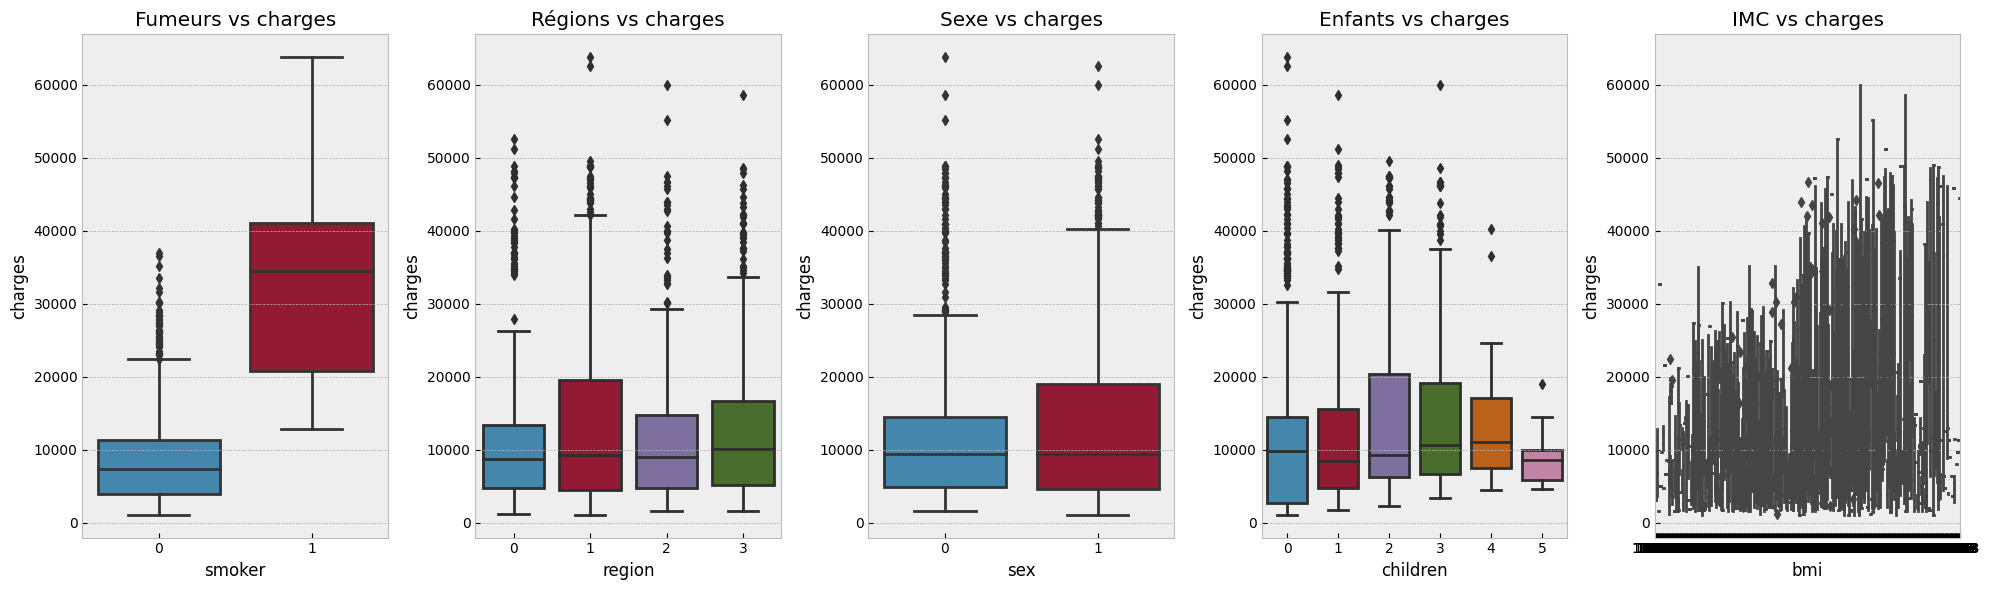

In [730]:
fig, axes = plt.subplots(1, 5, figsize=(20, 6))

sns.boxplot(x='smoker', y='charges', data=df, ax=axes[0])
axes[0].set_title('Fumeurs vs charges')
df.groupby('smoker').agg(['mean','min','max'])['charges']

sns.boxplot(x='region', y='charges', data=df, ax=axes[1])
axes[1].set_title('Régions vs charges')
df.groupby('region').agg(['mean','min','max'])['charges']

sns.boxplot(x='sex', y='charges', data=df, ax=axes[2])
axes[2].set_title('Sexe vs charges')
df.groupby('sex').agg(['mean','min','max'])['charges']

sns.boxplot(x='children', y='charges', data=df, ax=axes[3])
axes[3].set_title('Enfants vs charges')
df.groupby('children').agg(['mean','min','max'])['charges']

sns.boxplot(x='bmi', y='charges', data=df, ax=axes[4])
axes[4].set_title('IMC vs charges')
df.groupby('bmi').agg(['mean','min','max'])['charges']

plt.tight_layout()

La médiane des charges des non-fumeurs est très largement inférieure à celles des fumeurs.
Aussi, la valeur maximimale de charges payées par un fumeur est de 63770€ contrairement aux non fumeurs, situées à un peu moins de 40000€. 

Ce boxplot nous indique donc que les deux groupes ont des distributions de charges différentes, sans pour autant impliquer que le tabagisme est la cause de cette différence. En effet, il est possible que d'autres facteurs tels que l'âge, le sexe, le régime alimentaire ou les antécédents médicaux puissent influencer les niveaux de charges dans les deux groupes.

On peut remarquer que la médiane de charges médicales payées est égale pour tous les boxplots représentant chaque région.

On peut remarquer que la médiane de charges médicales payées est égale pour les boxplots de sexe féminin et masculin.

A interpreter

A interpreter
Pk c'est pas un boxplot comme les autres ?

In [731]:
#Scatter Matrix plot
#sns.pairplot(df)

A interpréter

## Pairplots

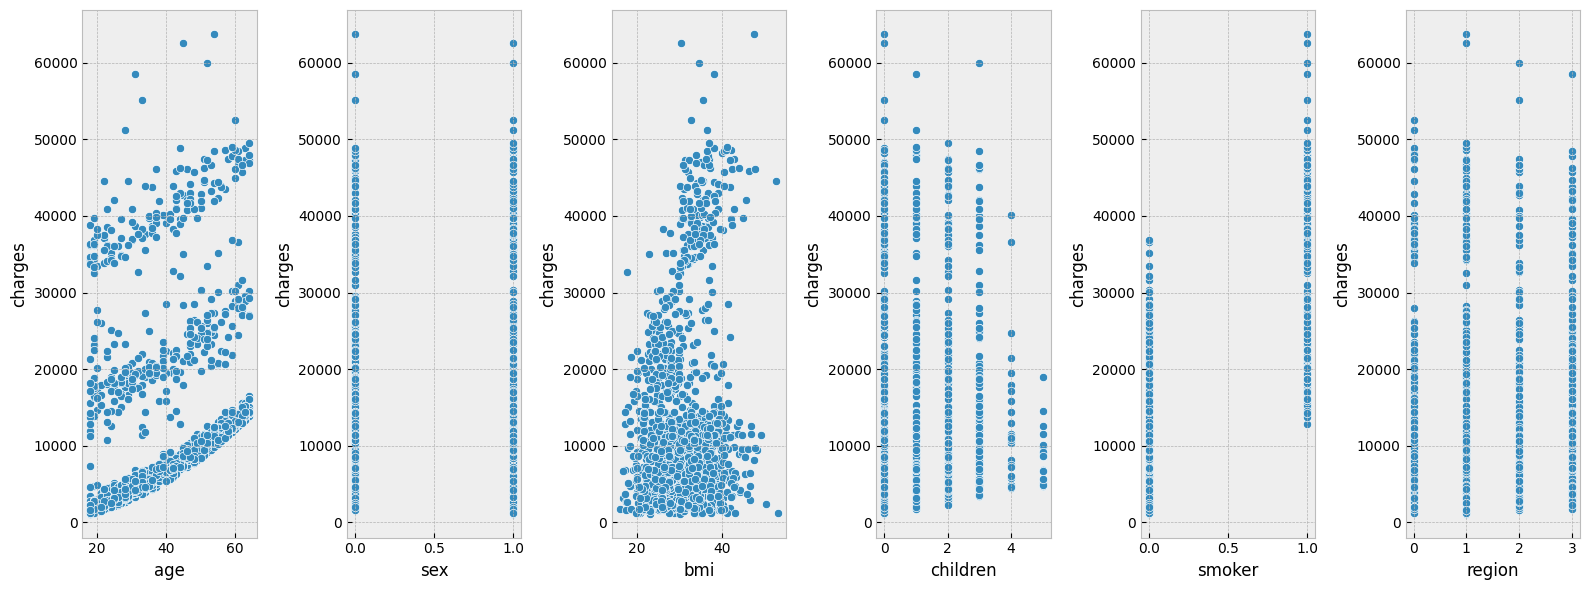

In [732]:
fig, axes = plt.subplots(1, 6, figsize=(16, 6))

sns.scatterplot(data=df, x='age', y='charges', ax=axes[0])
sns.scatterplot(data=df, x='sex', y='charges', ax=axes[1])
sns.scatterplot(data=df, x='bmi', y='charges', ax=axes[2])
sns.scatterplot(data=df, x='children', y='charges', ax=axes[3])
sns.scatterplot(data=df, x='smoker', y='charges', ax=axes[4])
sns.scatterplot(data=df, x='region', y='charges', ax=axes[5])

plt.tight_layout()

## Corrélations


There are 4 lowly correlated values and 1 highly correlated value with Charges:
smoker      0.787251
age         0.299008
bmi         0.198341
children    0.067998
sex         0.057292
region      0.006208
Name: charges, dtype: float64


<Axes: >

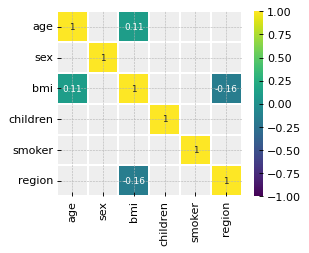

In [733]:
dfcorr = df.corr()['charges'][:-1]
golden_features_list = dfcorr.sort_values(ascending=False)
print(
    "\nThere are {} lowly correlated values and 1 highly correlated value with Charges:\n{}"
    .format(len(golden_features_list) - 2, golden_features_list))

corr = df.drop('charges',
               axis=1).corr()  # We already examined Charges correlations
plt.figure(figsize=(4, 3), dpi=80)

sns.heatmap(corr[(corr >= 0.1) | (corr <= -0.1)],
            cmap='viridis',
            vmax=1.0,
            vmin=-1.0,
            linewidths=0.1,
            annot=True,
            annot_kws={"size": 8},
            square=True)

Les variables sont très peu corrélées. Mesurons les colinéarités par les facteurs d’inflation de la variance.

Conclusion : si on enlève des données inutiles ou pas ?

## Split du jeu de données en jeu d'entraînement et de test

Nous allons débuter par diviser notre jeu de données en un jeu d'entraînement et un jeu de tests
30% des données seront de test, et 70% seront d'entraînement.
Le random_state = 42 nous garantie que les mêmes jeux de données sont obtenues à chaque exécution du code. C'est particulièrement important pour la reproductibilité des résultats dans les expériences de machine learning. Nous l'avons fixé arbitrairement à 42.

In [734]:
X = df.drop(['charges'], axis=1)
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)

X_train: un DataFrame contenant les données d'entraînement pour les variables explicatives (toutes les colonnes de 'df' à l'exception de 'charges').
y_train: une série contenant les données d'entraînement pour la variable cible (la colonne 'charges').
X_test: un DataFrame contenant les données de test pour les variables explicatives.
y_test: une série contenant les données de test pour la variable cible.

Nous allons maintenant entraîner un modèle à trouver un lien entre y_train (sorites) et X_train (entrées)

# Entraînement

## Construction des modèles


Nous débutons par le modèle de régression linéaire car c'est l'une des méthodes de régression les plus simples. L'un de ses principaux avantages est la facilité d'interprétation des résultats.

### Modèle de régression linéaire

In [735]:
# Création d'un objet modeleRegressionLineaire de régression linéaire
modeleRegressionLineaire = LinearRegression()

# Entraînement du modèle sur les données d'entraînement
#Pour obtenir les meilleures pondérations, une minimisation de la somme des carrés des résidus (SSR) sera cherchée, pour toutes les observations.
# Il s'agit de la méthode des moindres carrés ordinaires.
modeleRegressionLineaire.fit(X_train, y_train)

LinearRegression()

### Modèle de régression lasso

Nous commençons par effectuer une mise à l'échelle de notre jeu de données, afin de ne pas pénaliser les valeurs élevées avec la mise en place d'un hyperparamètre alpha.

In [736]:
scale = StandardScaler()

X_trainScaled = scale.fit_transform(X_train)
X_testScaled = scale.fit_transform(X_test)

Puis, afin de choisir le meilleur hyperparamètre alpha, nous allons effectuer une "K Fold Cross-Validation"

In [737]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso

kf = KFold(n_splits=10, shuffle=True)

#Valeurs de alpha à tester
alphas = [0.001, 0.01, 0.1, 1, 5, 10, 50, 75, 100, 500, 1000]
scores = []

for alpha in alphas:
    # Initialiser une liste pour stocker les scores de validation pour ce modèle
    alpha_scores = []
    # Parcourir les différentes itérations de la validation croisée
    for train_index, val_index in kf.split(X_trainScaled, y_train):
        # Extraire les données d'entraînement et de validation pour cette itération
        X_train_fold, X_val_fold = X_trainScaled[train_index], X_trainScaled[val_index]
        y_train_fold, y_val_fold = y_train.values[train_index], y_train.values[val_index]
       
        # Créer un modèle Lasso avec l'alpha actuel et entraîner le modèle sur les données d'entraînement
        modeleRegressionLineaireLasso = Lasso(alpha=alpha)
        modeleRegressionLineaireLasso.fit(X_train_fold, y_train_fold)
        # Calculer le score de validation pour ce modèle et l'ajouter à la liste des scores pour cette alpha
        score = modeleRegressionLineaireLasso.score(X_val_fold, y_val_fold)
        alpha_scores.append(score)
    # Calculer la moyenne des scores de validation pour ce modèle et l'ajouter à la liste des scores pour tous les alphas
    mean_score = np.mean(alpha_scores)
    scores.append(mean_score)

# Trouver l'alpha qui donne le meilleur score de validation
best_alpha_lasso = alphas[np.argmax(scores)]   
print("Pour Lasso, le meilleur alpha est : ",best_alpha_lasso)

Pour Lasso, le meilleur alpha est :  0.01


### Modèle de régression ridge

Nous allons utiliser les jeux d'entraînement mis à l'échelle, et effectuer une "K Fold Cross-Validation"

In [738]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso

kf = KFold(n_splits=10, shuffle=True)

#Valeurs de alpha à tester
alphas = [0.001, 0.01, 0.1, 1, 5, 10, 50, 75, 100, 500, 1000]
scores = []

for alpha in alphas:
    # Initialiser une liste pour stocker les scores de validation pour ce modèle
    alpha_scores = []
    # Parcourir les différentes itérations de la validation croisée
    for train_index, val_index in kf.split(X_trainScaled, y_train):
        # Extraire les données d'entraînement et de validation pour cette itération

        X_train_fold, X_val_fold = X_trainScaled[train_index], X_trainScaled[val_index]
        y_train_fold, y_val_fold = y_train.values[train_index], y_train.values[val_index]
       
        # Créer un modèle Ridge avec l'alpha actuel et entraîner le modèle sur les données d'entraînement
        modeleRegressionLineaireRidge = Ridge(alpha=alpha)
        modeleRegressionLineaireRidge.fit(X_train_fold, y_train_fold)
        # Calculer le score de validation pour ce modèle et l'ajouter à la liste des scores pour cette alpha
        score = modeleRegressionLineaireRidge.score(X_val_fold, y_val_fold)
        alpha_scores.append(score)
    # Calculer la moyenne des scores de validation pour ce modèle et l'ajouter à la liste des scores pour tous les alphas
    mean_score = np.mean(alpha_scores)
    scores.append(mean_score)

# Trouver l'alpha qui donne le meilleur score de validation
best_alpha_ridge = alphas[np.argmax(scores)]   
print("Pour Ridge, le meilleur alpha est : ",best_alpha_ridge)

Pour Ridge, le meilleur alpha est :  1


### Ce que disent les modèles


In [739]:
for idx, col_name in enumerate(X_train.columns):
    print("Coefficients Betas de {} =>\n[regression Lasso alpha = ",best_alpha_lasso," {}\n[regression Ridge alpha = ",best_alpha_ridge,"] {} \n".format(
        col_name, modeleRegressionLineaire.coef_[idx], modeleRegressionLineaireLasso.coef_[idx],modeleRegressionLineaireRidge.coef_[idx]))

Coefficients Betas de {} =>
[regression Lasso alpha =  0.01  {}
[regression Ridge alpha 1 ] age 

Coefficients Betas de {} =>
[regression Lasso alpha =  0.01  {}
[regression Ridge alpha 1 ] sex 

Coefficients Betas de {} =>
[regression Lasso alpha =  0.01  {}
[regression Ridge alpha 1 ] bmi 

Coefficients Betas de {} =>
[regression Lasso alpha =  0.01  {}
[regression Ridge alpha 1 ] children 

Coefficients Betas de {} =>
[regression Lasso alpha =  0.01  {}
[regression Ridge alpha 1 ] smoker 

Coefficients Betas de {} =>
[regression Lasso alpha =  0.01  {}
[regression Ridge alpha 1 ] region 



Les variables age, sex, bmi et region ont toutes un effet positif sur la variable cible Charges, et le nombre d'enfants ainsi que le tabagisme ont un effet encore plus positif. Il convient également de noter que le coefficient de la variable smoker est beaucoup plus élevé que celui des autres variables, ce qui indique que le modèle considère que le tabagisme a un effet beaucoup plus important sur les coûts de santé que les autres variables.

In [740]:
for idx, col_name in enumerate(X_train.columns):
    print("Valeurs intercept de {} =>\n[regression Lasso alpha = ",best_alpha_lasso,"] {}\n[regression Ridge alpha = ",best_alpha_ridge,"] {} \n".format(
        col_name, modeleRegressionLineaire.intercept_, modeleRegressionLineaireLasso.intercept_,modeleRegressionLineaireRidge.intercept_))

Valeurs intercept de {} =>
[regression Lasso alpha =  0.01  {}
[regression Ridge alpha 1 ] age 

Valeurs intercept de {} =>
[regression Lasso alpha =  0.01  {}
[regression Ridge alpha 1 ] sex 

Valeurs intercept de {} =>
[regression Lasso alpha =  0.01  {}
[regression Ridge alpha 1 ] bmi 

Valeurs intercept de {} =>
[regression Lasso alpha =  0.01  {}
[regression Ridge alpha 1 ] children 

Valeurs intercept de {} =>
[regression Lasso alpha =  0.01  {}
[regression Ridge alpha 1 ] smoker 

Valeurs intercept de {} =>
[regression Lasso alpha =  0.01  {}
[regression Ridge alpha 1 ] region 



Ce résultat indique que lorsque toutes les variables explicatives (âge, sexe, IMC, nombre d'enfants, tabagisme et région) sont nulles, la charge moyenne pour une personne est d'environ -13252,02 euros. On ne peut pas vraiment interpreter cette valeur car cette situation ne peut pas se réaliser.

### Evaluation quantitative des modèles

Nous commencons par calculer le coefficient de détermination R² du modèle.
Il indique dans quelle mesure la variation de 𝑦 peut être expliquée par la dépendance à X, en utilisant le modèle de régression en question. Un R² plus grand indique une meilleure adéquation et signifie que le modèle peut mieux expliquer la variation de la production avec différentes entrées. Par exemple, un 𝑅²égal à 1 corresponds à SSR = 0. Il s'agit d'un ajustement parfait, puisque les valeurs des réponses prédites et réelles s'accordent parfaitement entre elles.

In [741]:
for idx, col_name in enumerate(X_train.columns):
    print("Scores de {} =>\n[regression linéaire] {} \n[regression Lasso alpha = {}] {}\n[regression Ridge alpha = {}] {}\n".format(
        col_name,modeleRegressionLineaire.score(X_test, y_test),
        best_alpha_lasso, modeleRegressionLineaireLasso.score(X_test, y_test),
        best_alpha_ridge, modeleRegressionLineaireRidge.score(X_test, y_test)))

Scores de age =>
[regression linéaire] 0.7694415927057693 
[regression Lasso alpha = 0.01] -150.65451170043156
[regression Ridge alpha = 1] -68.14704471644178

Scores de sex =>
[regression linéaire] 0.7694415927057693 
[regression Lasso alpha = 0.01] -150.65451170043156
[regression Ridge alpha = 1] -68.14704471644178

Scores de bmi =>
[regression linéaire] 0.7694415927057693 
[regression Lasso alpha = 0.01] -150.65451170043156
[regression Ridge alpha = 1] -68.14704471644178

Scores de children =>
[regression linéaire] 0.7694415927057693 
[regression Lasso alpha = 0.01] -150.65451170043156
[regression Ridge alpha = 1] -68.14704471644178

Scores de smoker =>
[regression linéaire] 0.7694415927057693 
[regression Lasso alpha = 0.01] -150.65451170043156
[regression Ridge alpha = 1] -68.14704471644178

Scores de region =>
[regression linéaire] 0.7694415927057693 
[regression Lasso alpha = 0.01] -150.65451170043156
[regression Ridge alpha = 1] -68.14704471644178



C:\Users\33660\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
C:\Users\33660\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
C:\Users\33660\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
C:\Users\33660\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
 

Un R² de 0,76 indique que le modèle de régression linéaire est capable d'expliquer 76% de la variance de la variable cible en utilisant les variables explicatives. Le modèle est donc relativement performant.
En revanche, R² ne suffit pas à évaluer la qualité du modèle.

### Evaluation qualitative des modèles

On peut voir que le modèle suit plus ou moins la droite des y=x pour des charges inféireures à 15 000 euros, mais après, les valeurs s'éloignent plus de cette droite.

In [742]:
predictionChargesRegressionLineaires = modeleRegressionLineaireLasso.predict(X_test)
predictionChargesRegressionLineairesLasso = modeleRegressionLineaireLasso.predict(X_testScaled)
predictionChargesRegressionLineairesRidge = modeleRegressionLineaireRidge.predict(X_testScaled)

C:\Users\33660\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


Text(0.5, 0.98, 'Dispersion des résidus')

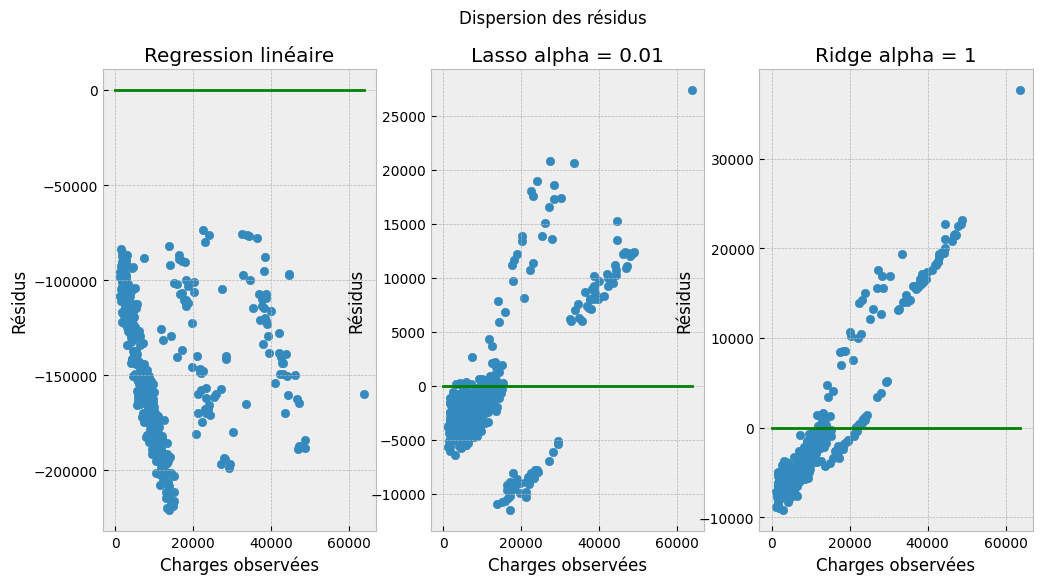

In [744]:
residusRegressionLineaire = y_test - predictionChargesRegressionLineaires
residusRegressionLasso = y_test - predictionChargesRegressionLineairesLasso
residusRegressionRidge = y_test - predictionChargesRegressionLineairesRidge


fig, axes = plt.subplots(1, 3, figsize=(12, 6)) # spécifie la taille de la figure
axes[0].scatter(y_test, residusRegressionLineaire)
axes[0].set_xlabel("Charges observées")
axes[0].set_ylabel("Résidus")
axes[0].set_title("Regression linéaire")
axes[0].plot([0, max(y_test)], [0, 0], color='g')

axes[1].scatter(y_test, residusRegressionLasso)
axes[1].set_xlabel("Charges observées")
axes[1].set_ylabel("Résidus")
axes[1].set_title("Lasso alpha = {}".format(best_alpha_lasso))
axes[1].plot([0, max(y_test)], [0, 0], color='g')

axes[2].scatter(y_test, residusRegressionRidge)
axes[2].set_xlabel("Charges observées")
axes[2].set_ylabel("Résidus")
axes[2].set_title("Ridge alpha = {}".format(best_alpha_ridge))
axes[2].plot([0, max(y_test)], [0, 0], color='g')

fig.suptitle("Dispersion des résidus")

On peut observer des valeurs de résidus très importantes. A ce stade, on ne peut pas toutes les supprimer puisqu'on se rend compte qu'elles sont trop nombreuses. On voit particulièrement un groupe d'outliers autour des charges prédites à 30 000 euros, avec des résidus de -10 000 euros, signifiant que notre modèle a surestimé de 10 000 euros les charges, ce qui est très excessif. On peut aussi observer des valeurs d'extrêmes sous-estimations d'environ 20 000 euros pour des prédictions de 10 000 euros.

In [ ]:
print("Moyenne des résidus =>\n[regression linéaire]{}\n[regression Lasso alpha = ",best_alpha_lasso,"] {}\n[regression Ridge alpha = ",best_alpha_ridge,"]".format(
    statistics.mean(residusRegressionLineaire), statistics.mean(residusRegressionLasso), statistics.mean(residusRegressionRidge)))

print("Variance des résidus =>\n[regression linéaire]{}\n[regression Lasso alpha = ",best_alpha_lasso,"]{}\n[regression Ridge alpha = ",best_alpha_ridge,"]".format(
    statistics.variance(residusRegressionLineaire), statistics.variance(residusRegressionLasso), statistics.variance(residusRegressionRidge)))

Moyenne des résidus =>
[regression linéaire]{}
[regression Lasso alpha =  0.001 ] {}
[regression Ridge alpha =  10 ]
Variance des résidus =>
[regression linéaire]{}
[regression Lasso alpha =  0.001 ]{}
[regression Ridge alpha =  10 ]


Aussi, on voit que la variance des résidus n'est pas homogène.

Nous allons visualiser la distribution des erreurs de prédiction de notre modèle de régression linéaire, c'est-à-dire la différence entre les valeurs réelles de la variable cible (y_test) et les valeurs prédites par le modèle (predictionChargesRegressionLineaires).
Si l'histogramme des écarts obtenus est centré autour de zéro et suit une distribution normale, cela signifie que les erreurs de prédiction sont faibles et que notre modèle est capable de faire des prédictions précises. En revanche, si l'histogramme présente une distribution asymétrique ou est centré autour d'une valeur non nulle, cela peut indiquer la présence de biais ou d'erreurs systématiques dans notre modèle.

Text(0.5, 0.98, 'Répartition des résidus')

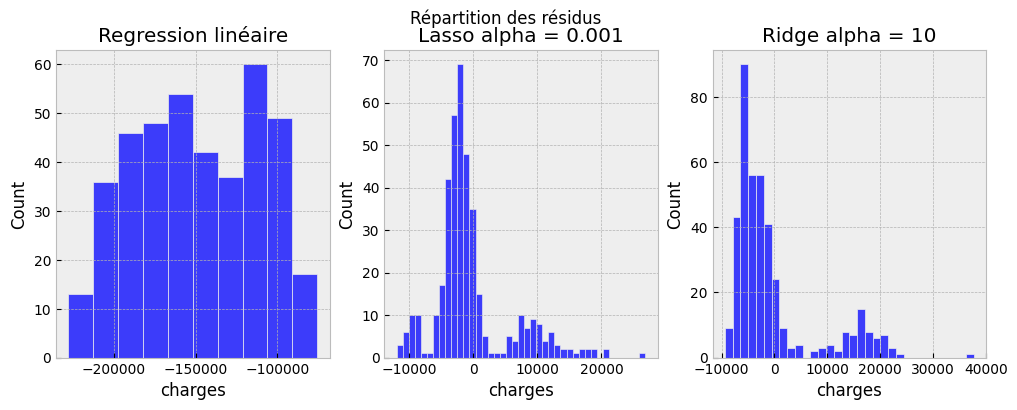

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4)) # spécifie la taille de la figure

# Tracer l'histogramme pour la régression linéaire
sns.histplot(residusRegressionLineaire, color='blue', ax=axes[0])
axes[0].set_title("Regression linéaire")

# Tracer l'histogramme pour la régression Lasso
sns.histplot(residusRegressionLasso, color='blue', ax=axes[1])
axes[1].set_title("Lasso alpha = {}".format(best_alpha_lasso))

# Tracer l'histogramme pour la régression Ridge
sns.histplot(residusRegressionRidge, color='blue', ax=axes[2])
axes[2].set_title("Ridge alpha = {}".format(best_alpha_ridge))

plt.suptitle("Répartition des résidus")

Text(0.5, 0.98, 'Mise en parallèle des valeurs prédites et observées')

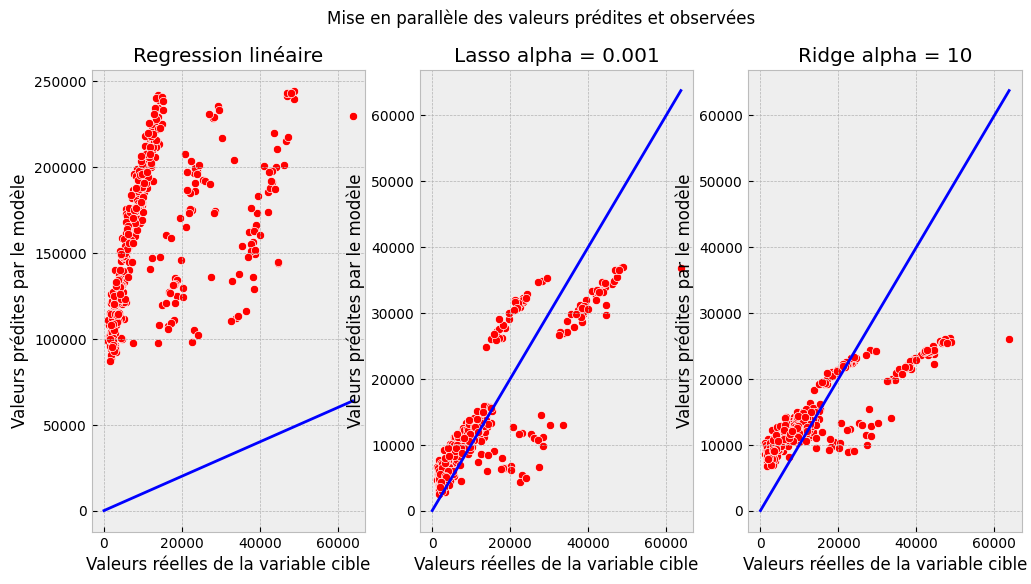

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6)) # spécifie la taille de la figure
sns.scatterplot(ax=axes[0], x=y_test, y=predictionChargesRegressionLineaires, color='r')
axes[0].set_xlabel("Valeurs réelles de la variable cible")
axes[0].set_ylabel("Valeurs prédites par le modèle")
axes[0].set_title("Regression linéaire")
axes[0].plot([0, max(y_test)], [0, max(y_test)], color='b')

sns.scatterplot(ax=axes[1], x=y_test, y=predictionChargesRegressionLineairesLasso, color='r')
axes[1].set_xlabel("Valeurs réelles de la variable cible")
axes[1].set_ylabel("Valeurs prédites par le modèle")
axes[1].set_title("Lasso alpha = {}".format(best_alpha_lasso))
axes[1].plot([0, max(y_test)], [0, max(y_test)], color='b')

sns.scatterplot(ax=axes[2], x=y_test, y=predictionChargesRegressionLineairesRidge, color='r')
axes[2].set_xlabel("Valeurs réelles de la variable cible")
axes[2].set_ylabel("Valeurs prédites par le modèle")
axes[2].set_title("Ridge alpha = {}".format(best_alpha_ridge))
axes[2].plot([0, max(y_test)], [0, max(y_test)], color='b')

plt.suptitle("Mise en parallèle des valeurs prédites et observées")

Text(0.5, 1.0, 'Ridge alpha = 10')

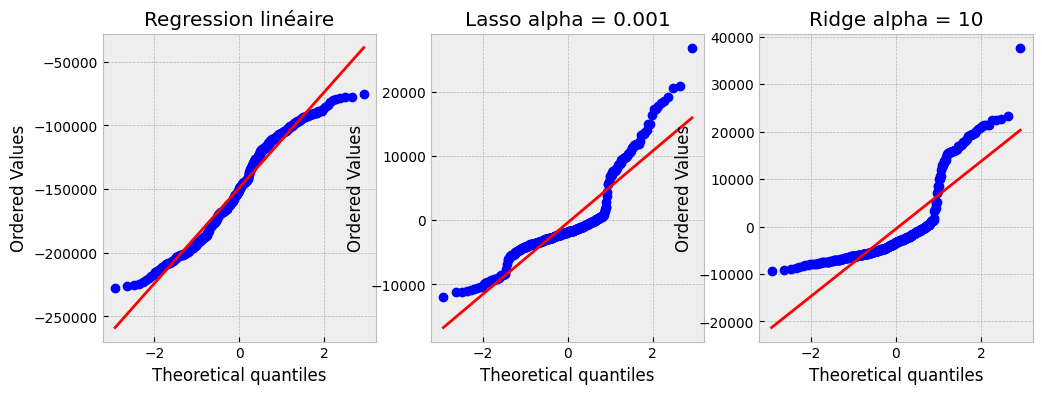

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12,4)) # spécifie la taille de la figure

# Tracer le graphique de probabilité normale pour la régression linéaire
_, (_, _, r) = sp.stats.probplot(residusRegressionLineaire, fit=True, plot=axes[0])
axes[0].set_title('Regression linéaire')

# Tracer le graphique de probabilité normale pour la régression linéaire Lasso
_, (_, _, r) = sp.stats.probplot(residusRegressionLasso, fit=True, plot=axes[1])
axes[1].set_title("Lasso alpha = {}".format(best_alpha_lasso))

# Tracer le graphique de probabilité normale pour la régression linéaire Ridge
_, (_, _, r) = sp.stats.probplot(residusRegressionRidge, fit=True, plot=axes[2])
axes[2].set_title("Ridge alpha = {}".format(best_alpha_ridge))

#### Homostédasticité

Text(0.5, 1.0, 'Ridge alpha = 1')

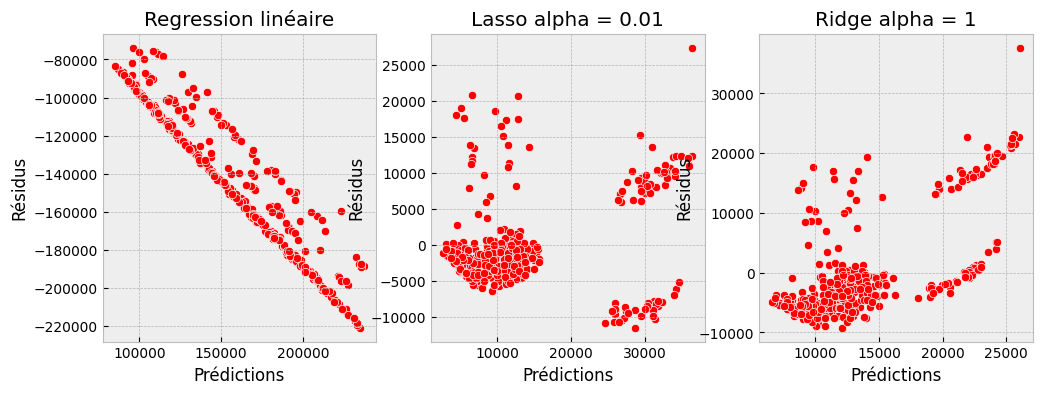

In [745]:
fig, axes = plt.subplots(1, 3, figsize=(12,4)) # spécifie la taille de la figure

# Tracer la dispersion des résidus pour la régression linéaire
sns.scatterplot(y=residusRegressionLineaire, x=predictionChargesRegressionLineaires, color='r', ax=axes[0])
axes[0].set_xlabel("Prédictions")
axes[0].set_ylabel("Résidus")
axes[0].set_title("Regression linéaire")

# Tracer la dispersion des résidus pour la régression linéaire Lasso
sns.scatterplot(y=residusRegressionLasso, x=predictionChargesRegressionLineairesLasso, color='r', ax=axes[1])
axes[1].set_xlabel("Prédictions")
axes[1].set_ylabel("Résidus")
axes[1].set_title("Lasso alpha = {}".format(best_alpha_lasso))

# Tracer la dispersion des résidus pour la régression linéaire Ridge
sns.scatterplot(y=residusRegressionRidge, x=predictionChargesRegressionLineairesRidge, color='r', ax=axes[2])
axes[2].set_xlabel("Prédictions")
axes[2].set_ylabel("Résidus")
axes[2].set_title("Ridge alpha = {}".format(best_alpha_ridge))

On peut conclure que le modèle de régression linénaire Lasso n'a pas amélioré la prédiction du jeu de tests par rapport au modèle de régression linéaire. Nous allons donc maintenant passder à un autre modèle : le modèle de régression linéaire Ridge, et l'évaluer quantitativement et qualitativement par rapport à la régression linéaire Lasso, qui a tout de même un tout petit peu réduit les valeurs des coefficients Beta, en minimisant leur norme 2 avec un alpha égal à 1.